# LDA方法分析红楼梦各回主题
钟欣然 2016201731

本文主要包括四个部分，第一部分为数据预处理，主要包括读入《红楼梦》文本文件，对其进行分词和去停词；第二部分展示《红楼梦》的基本情况，包括全文的词频表和词云图、各主要人物在各章节的出场情况，并根据人物出场情况进行了一些探索性分析；第三部分对《红楼梦》建立LDA模型，得到初步的模型结果，并可视化展示各主题的词云图；第四部分回应课程任务，包括：（1）随机抽取40篇作为训练样本，训练完成后，对剩下的40回进行分类，判断和训练样本中的那些回比较接近（2）使用全部八十回，在LDA分析基础上，进行分类，看看哪些回在主题分布上比较接近。

<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-数据预处理" data-toc-modified-id="1-数据预处理-1">1 数据预处理</a></span><ul class="toc-item"><li><span><a href="#1.1-准备工作" data-toc-modified-id="1.1-准备工作-1.1">1.1 准备工作</a></span></li><li><span><a href="#1.2-读入文本" data-toc-modified-id="1.2-读入文本-1.2">1.2 读入文本</a></span></li><li><span><a href="#1.3-分词、去停词" data-toc-modified-id="1.3-分词、去停词-1.3">1.3 分词、去停词</a></span></li></ul></li><li><span><a href="#2-基本情况" data-toc-modified-id="2-基本情况-2">2 基本情况</a></span><ul class="toc-item"><li><span><a href="#2.1-全文词频及词云图" data-toc-modified-id="2.1-全文词频及词云图-2.1">2.1 全文词频及词云图</a></span></li><li><span><a href="#2.2-人物出场情况" data-toc-modified-id="2.2-人物出场情况-2.2">2.2 人物出场情况</a></span></li><li><span><a href="#2.3-宝玉的cp" data-toc-modified-id="2.3-宝玉的cp-2.3">2.3 宝玉的cp</a></span></li></ul></li><li><span><a href="#3-LDA分析红楼梦各回的主题" data-toc-modified-id="3-LDA分析红楼梦各回的主题-3">3 LDA分析红楼梦各回的主题</a></span><ul class="toc-item"><li><span><a href="#3.1-数据准备" data-toc-modified-id="3.1-数据准备-3.1">3.1 数据准备</a></span></li><li><span><a href="#3.2-训练模型" data-toc-modified-id="3.2-训练模型-3.2">3.2 训练模型</a></span></li><li><span><a href="#3.3-模型结果" data-toc-modified-id="3.3-模型结果-3.3">3.3 模型结果</a></span></li></ul></li><li><span><a href="#4-回应课程任务" data-toc-modified-id="4-回应课程任务-4">4 回应课程任务</a></span><ul class="toc-item"><li><span><a href="#4.1-任务1" data-toc-modified-id="4.1-任务1-4.1">4.1 任务1</a></span></li><li><span><a href="#4.2-任务2" data-toc-modified-id="4.2-任务2-4.2">4.2 任务2</a></span></li></ul></li></ul></div>

### 1 数据预处理
#### 1.1 准备工作
引入需要的模块，设置显示方式，修改工作路径，如未安装jieba包需要在命令行中输入pip install jieba安装

In [1]:
import os
import re
import jieba
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.image as mpimg
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.interpolate import spline
import random
from scipy.cluster import hierarchy
from sklearn import decomposition as skldec

# 设置字体
font = mpl.font_manager.FontProperties(fname='C:\Windows\Fonts\STXINWEI.TTF')
# 设置pandas显示方式
pd.set_option("display.max_rows",10)
pd.options.mode.chained_assignment = None  # default='warn'

# 设置显示图像的方式
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%config InlineBackend.figure_format = "retina"

os.chdir("C:\Aruc\learning\大四上\贝叶斯\LDA")
print(os.getcwd())

C:\Aruc\learning\大四上\贝叶斯\LDA


#### 1.2 读入文本
首先读入红楼梦文本，并按照章节处理为列表，再读入停用词表（合并了红楼梦停用词表、哈工大停用词表、四川大学停用词表、中文停用词表等）

In [2]:
# 读入红楼梦文本
f = open('红楼梦.txt',encoding='utf-8')
quanwen = f.read()
quanwen.replace('\n','')
# 出现“第xx回 ”则断开
quanwen_list = re.split('第[\u4e00-\u9fa5]{1,3}回 ',quanwen)[1:121]

# 读入停用词表
f = open('stopword1.txt')
stop_words = f.readlines()
for i in range(len(stop_words)):
    stop_words[i] = stop_words[i].replace('\n','')
    
print('红楼梦共有{}章，{}个停用词'.format(len(quanwen_list),len(stop_words)))

红楼梦共有120章，1604个停用词


#### 1.3 分词、去停词
每章分别分词、去停词，同时将长度为1的字符删掉，将结果分章节保存

In [3]:
# 分词、去停词
jieba.load_userdict('红楼梦分词词典.txt')
quanwen_fenci = []
for i in range(len(quanwen_list)):
    temps = list(jieba.cut(quanwen_list[i]))
    quanwen_fenci.append([])
    for temp in temps:
        # 将长度为1的字符删掉
        if len(temp) > 1 and temp not in stop_words:
            quanwen_fenci[i].append(temp)

# 将结果分章节保存
for i in range(len(quanwen_fenci)):
    with open('红楼梦分章节分词/{}.json'.format(i),'w',encoding='utf-8') as f:
        json.dump(quanwen_fenci[i],f)

# 查看第一章前100分分词结果
print(quanwen_fenci[0][0:100])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zhong\AppData\Local\Temp\jieba.cache
Loading model cost 0.762 seconds.
Prefix dict has been built succesfully.


['甄士隐', '梦幻', '识通灵', '贾雨村', '风尘', '闺秀', '开卷', '第一回', '作者', '自云', '因曾', '历过', '梦幻', '之后', '真事', '隐去', '通灵', '撰此', '石头记', '一书', '故曰', '甄士隐', '但书中', '所记', '何事', '何人', '自又云', '风尘碌碌', '一事无成', '念及', '当日', '女子', '细考', '觉其', '行止', '见识', '之上', '堂堂', '须眉', '诚不若', '裙钗', '实愧', '有余', '无益', '之大', '无可如何', '之日', '自欲', '已往', '所赖', '天恩祖', '锦衣', '纨绔', '饫甘餍肥', '父兄', '教育', '之恩', '师友', '规谈', '之德', '今日', '一技无成', '半生', '潦倒', '之罪', '编述', '一集', '以告', '天下人', '罪固', '闺阁', '中本', '历历', '有人', '不可', '不肖', '自护己', '一并', '泯灭', '今日', '之茅', '椽蓬', '瓦灶', '绳床', '晨夕', '风露', '阶柳庭花', '未有', '襟怀', '笔墨', '未学', '下笔', '无文', '假语', '村言', '演出', '一段', '故事', '亦可', '闺阁']


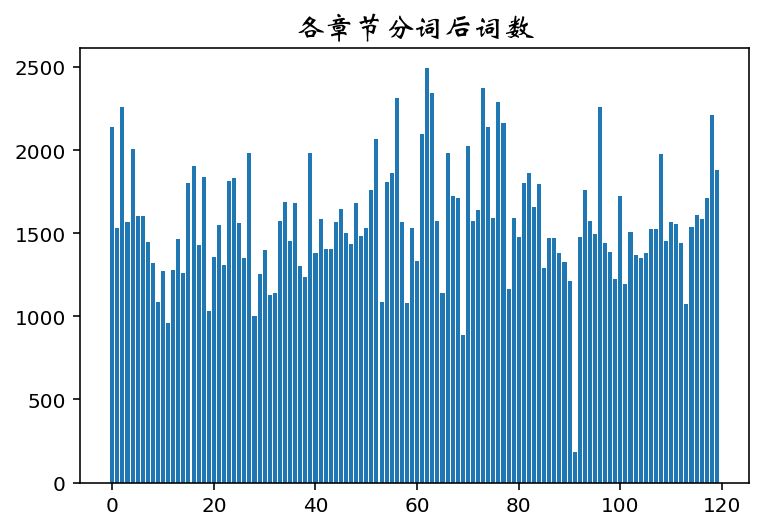

In [4]:
# 绘制各章节分词后词数
chapter_lens = [len(fenci) for fenci in quanwen_fenci]
p1 = plt.bar(range(len(chapter_lens)),chapter_lens)
plt.title("各章节分词后词数", fontproperties=font,size = 15)
plt.show()

每个章节的词数在1500上下波动

### 2 基本情况
#### 2.1 全文词频及词云图
统计全文的词频并展示结果，绘制全文及部分章节的词云图

In [5]:
# 统计全文的词频
word_df = pd.DataFrame({'word':np.concatenate(quanwen_fenci)})
word_stat = word_df.groupby(by = 'word')['word'].agg({'number':np.size})
# 调整为按词频由高到低展示
word_stat = word_stat.reset_index().sort_values(by='number',ascending=False)
word_stat

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,word,number
14253,宝玉,3653
34618,贾母,1233
7490,凤姐,1184
33165,袭人,1108
39821,黛玉,1007
...,...,...
16876,得备,1
16875,得善缘,1
16874,得十来,1
16872,得力,1


全文共有39882个词语，宝玉、贾母、凤姐、袭人、黛玉等主角人物出现次数最多

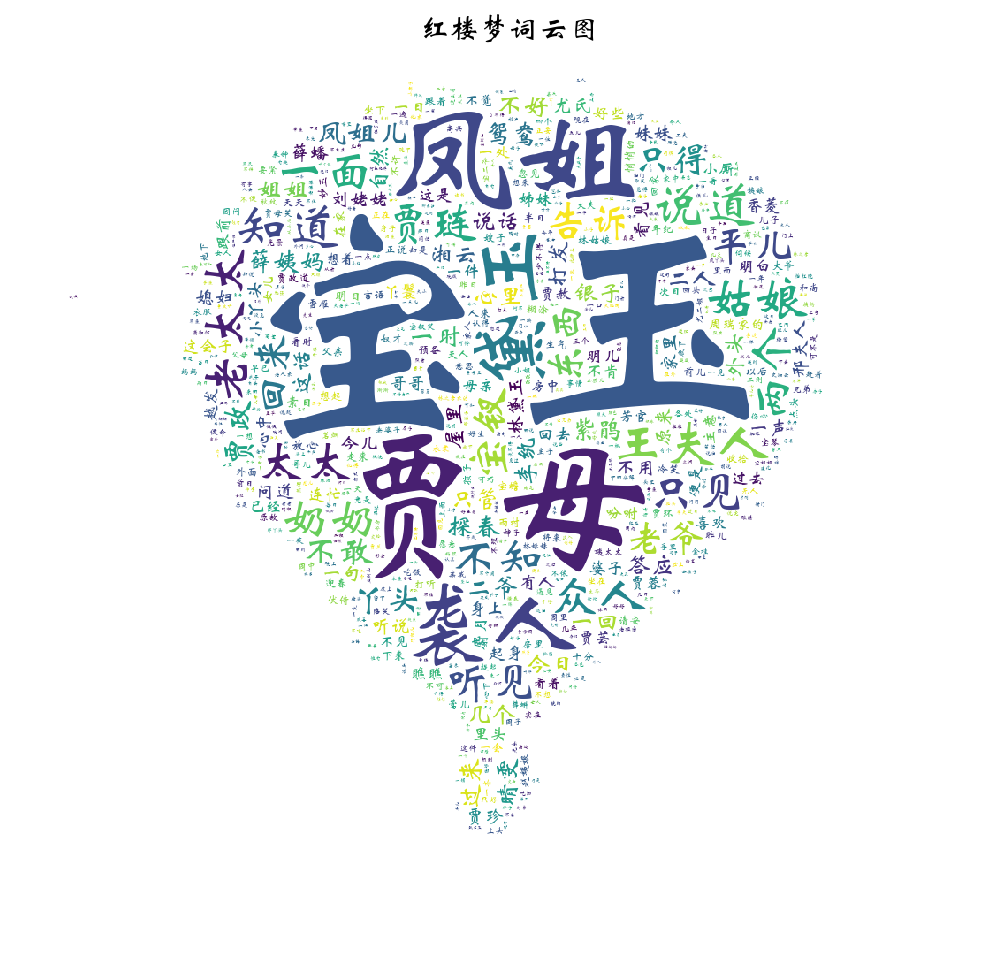

In [6]:
# 将词频数据框转化为字典
word_dict = {}
for key,value in zip(word_stat.word,word_stat.number):
    word_dict[key] = value
    
# 绘制词云
back_coloring = mpimg.imread('词云图片.jpg')
wc = WordCloud(font_path='C:\Windows\Fonts\STXINWEI.TTF',
               margin=5, width=2000, height=2000,
               background_color="white",
               max_words=800,
               mask=back_coloring,
               max_font_size=400,
               random_state=42,
               ).generate_from_frequencies(frequencies=word_dict)

plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.title('红楼梦词云图',FontProperties=font,size = 15)
plt.show()

#### 2.2 人物出场情况
读入人物名，查看各人物在各章的出场情况，并按照总出现次数由多到少排序，绘制出场情况曲线

In [7]:
# 读入人物名
f = open('红楼梦人物名.txt',encoding='utf-8')
names = f.readlines()
for i in range(len(names)):
    names[i] = names[i].replace('\n','')
    
# 输出前50个人物名
print(names[:50])

['黛玉', '宝钗', '贾演', '贾寅', '贾源', '贾法', '贾代化', '贾代善', '贾代儒', '贾代修', '贾敷', '贾敬', '贾赦', '贾政', '贾敏', '贾敕', '贾效', '贾敦', '贾珍', '贾琏', '贾珠', '贾母', '贾宝玉', '宝玉', '贾环', '贾瑞', '贾璜', '贾琮', '贾珩', '贾㻞', '贾珖', '贾琛', '贾琼', '贾璘', '贾元春', '贾迎春', '贾探春', '贾惜春', '贾蓉', '贾兰', '贾蔷', '贾菌', '贾芸', '贾芹', '贾萍', '贾菖', '贾菱', '贾蓁', '贾藻', '贾蘅']


In [8]:
# 计算每个词在每章的词频
for i in range(len(quanwen_fenci)):
    word_cha_stat = pd.DataFrame({'word':quanwen_fenci[i]}).groupby(by = 'word')['word'].agg({'chapter{}'.format(i):np.size})
    word_stat = pd.merge(word_stat, word_cha_stat, how='left', on='word')
word_stat = word_stat.where(word_stat.notnull(), 0)

# 仅保留人物的词频
word_name_stat = pd.DataFrame(columns = word_stat.columns)
for i in range(len(word_stat.word)):
    if word_stat.word[i] in names:
        word_name_stat = word_name_stat.append(word_stat.loc[i])

# 输出人物-词频矩阵
word_name_stat

C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,word,number,chapter0,chapter1,chapter2,chapter3,chapter4,chapter5,chapter6,chapter7,...,chapter110,chapter111,chapter112,chapter113,chapter114,chapter115,chapter116,chapter117,chapter118,chapter119
0,宝玉,3653,0.0,2.0,32.0,0.0,53.0,13.0,26.0,77.0,...,8.0,5.0,27.0,23.0,56.0,75.0,36.0,54.0,30.0,38.0
1,贾母,1233,0.0,0.0,18.0,3.0,4.0,2.0,3.0,13.0,...,5.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0
2,凤姐,1184,0.0,0.0,0.0,0.0,0.0,24.0,31.0,4.0,...,12.0,16.0,39.0,6.0,0.0,3.0,3.0,1.0,0.0,1.0
3,袭人,1108,0.0,0.0,8.0,0.0,3.0,10.0,0.0,6.0,...,3.0,0.0,2.0,2.0,5.0,4.0,20.0,13.0,8.0,29.0
4,黛玉,1007,0.0,1.0,72.0,3.0,5.0,0.0,5.0,21.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36937,小鸠儿,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37977,媚人,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38606,戚建辉,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39160,引愁金女,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\zhong\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


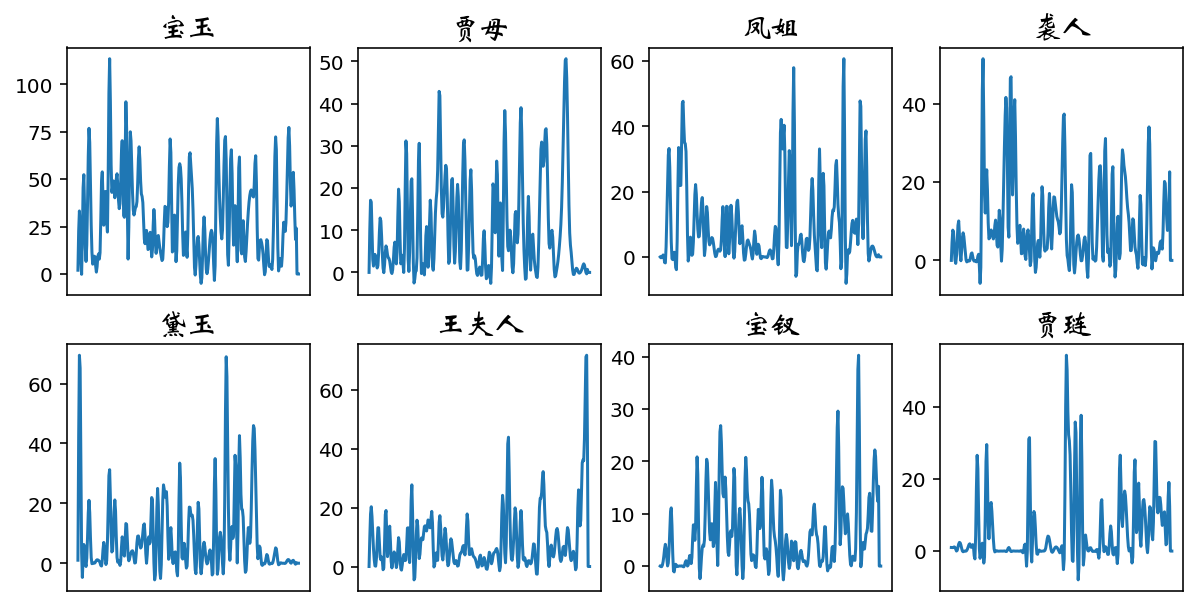

In [9]:
# 绘制出场最多的八个人物的出场曲线
fig = plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,1+i)
    # 平滑
    plt.plot(np.linspace(1,120,300),spline(range(120),word_name_stat.iloc[i,2:122].tolist(),np.linspace(1,120,300)))
    plt.title(word_name_stat.iloc[i,0],FontProperties=font,size = 15)
    plt.xticks([])
plt.show()

#### 2.3 宝玉的cp
在林妹妹、宝姐姐和袭人中，谁和宝玉的cp感最强呢？首先关注每个女性人物和宝玉的词频曲线波动趋势的吻合性，再关注每个女性人物和宝玉的cp指数，指数计算方式为计算每章中该女性人物的出现次数，乘以这一章中宝玉出场的比例（当前章节出现次数/全文总出现次数），最后对全文120个章节求和

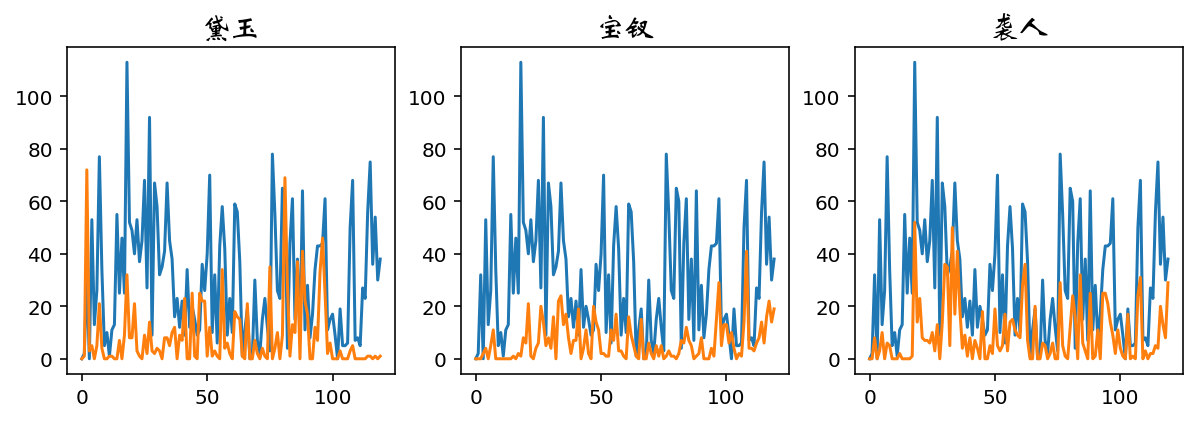

In [10]:
# 计算各女性人物的词频和cp指数
cps = ['黛玉','宝钗','袭人']
cp_nums = {}
baoyu_num = [num/word_name_stat.iloc[word_name_stat.word.tolist().index('宝玉'),1] for num in word_name_stat.iloc[word_name_stat.word.tolist().index('宝玉'),2:122]]
for cp in cps:
    cp_num = word_name_stat.iloc[word_name_stat.word.tolist().index(cp),2:122]
    cp_index = round(sum(np.multiply(np.array(baoyu_num),np.array(cp_num)).tolist()),2)
    cp_nums[cp] = [cp_num,cp_index]

# 分别绘制各女性角色和宝玉的词频曲线
fig = plt.figure(figsize=(10,3))
for i in range(len(cps)):
    plt.subplot(1,3,1+i)
    l1 = plt.plot(range(120),word_name_stat.iloc[word_name_stat.word.tolist().index('宝玉'),2:122])
    l2 = plt.plot(range(120),cp_nums[cps[i]][0])
    plt.title(cps[i],FontProperties=font,size = 15)
plt.show()

上图中蓝色线表示宝玉的词频曲线，橙色线表示女性角色的词频曲线，不难发现，袭人的词频曲线和宝玉的波动情况吻合度最高，接下来关注cp指数

In [11]:
cp_df = pd.DataFrame(cp_nums).drop([0])
cp_df.index = ["cp指数"]
cp_df

,黛玉,宝钗,袭人
cp指数,11.28,8.15,14.12


cp指数再一次印证了，袭人和宝玉一起出场的频率最高，其次是黛玉

### 3 LDA分析红楼梦各回的主题
#### 3.1 数据准备

In [20]:
# 将数据调整为CountVectorizer可调用的形式
articals = []
for fenci in quanwen_fenci:
    articals.append(" ".join(fenci))
# 展示前500个字符
articals[0][0:500]

'甄士隐 梦幻 识通灵 贾雨村 风尘 闺秀 开卷 第一回 作者 自云 因曾 历过 梦幻 之后 真事 隐去 通灵 撰此 石头记 一书 故曰 甄士隐 但书中 所记 何事 何人 自又云 风尘碌碌 一事无成 念及 当日 女子 细考 觉其 行止 见识 之上 堂堂 须眉 诚不若 裙钗 实愧 有余 无益 之大 无可如何 之日 自欲 已往 所赖 天恩祖 锦衣 纨绔 饫甘餍肥 父兄 教育 之恩 师友 规谈 之德 今日 一技无成 半生 潦倒 之罪 编述 一集 以告 天下人 罪固 闺阁 中本 历历 有人 不可 不肖 自护己 一并 泯灭 今日 之茅 椽蓬 瓦灶 绳床 晨夕 风露 阶柳庭花 未有 襟怀 笔墨 未学 下笔 无文 假语 村言 演出 一段 故事 亦可 闺阁 昭传 复可悦 世之目 破人 愁闷 宜乎 故曰 贾雨村 此回 中凡用 提醒 阅者 眼目 此书 立意 本旨 列位 看官 此书 从何而来 说起 根由 虽近 荒唐 深有 趣味 来历 注明 方使 阅者 了然 不惑 原来 女娲 炼石补天 大荒山 无稽 崖练成 高经 十二 方经 二十四丈 顽石 三万 六千五百 一块 皇氏 只用 三万 六千五百 一块 便弃 此山 青'

In [21]:
# 建立能用于模型训练的章节-词频矩阵
tf_vectorizer = CountVectorizer(max_features=10000)
tf = tf_vectorizer.fit_transform(articals)
# 查看词
print(tf_vectorizer.get_feature_names()[10:20])
# 查看词频
tf.toarray()[20:50,200:800]

['一两天', '一两日', '一两样', '一个个', '一个头', '一个月', '一串', '一丸', '一乘', '一事']


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)


#### 3.2 训练模型

In [30]:
# 主题数目
n_topics = 5
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=50, 
                                learning_method='online',                 
                                learning_offset=50., random_state=0)

# 模型应用于数据
lda.fit(tf)
# 得到每个章节属于某个主题的可能性
chapter_top = pd.DataFrame(lda.transform(tf),index=range(120),columns=np.arange(n_topics)+1)
chapter_top

C:\Users\zhong\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


,1,2,3,4,5
0,0.000154,0.000154,0.000154,0.999382,0.000157
1,0.000200,0.000200,0.000200,0.999195,0.000205
2,0.000117,0.000117,0.000117,0.103959,0.895690
3,0.000179,0.000179,0.000179,0.167604,0.831859
4,0.000175,0.000175,0.000175,0.999296,0.000179
...,...,...,...,...,...
115,0.000145,0.000145,0.000145,0.044129,0.955434
116,0.000144,0.000144,0.000144,0.000146,0.999424
117,0.000136,0.000136,0.000136,0.000138,0.999453
118,0.000102,0.000102,0.000102,0.000103,0.999592


#### 3.3 模型结果

In [31]:
# 每一行的和
chapter_top.apply(sum,axis=1).values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [32]:
# 查看每一列的最大值
chapter_top.apply(max,axis=1).values

array([0.9993818 , 0.99919544, 0.89569005, 0.83185936, 0.99929602,
       0.99939649, 0.99941162, 0.99931902, 0.99921217, 0.99904521,
       0.99926698, 0.99892742, 0.9991443 , 0.9992524 , 0.99919204,
       0.99942508, 0.99934276, 0.73443672, 0.99946176, 0.99911223,
       0.99926225, 0.99932175, 0.99919958, 0.99949226, 0.99947284,
       0.99940219, 0.99926442, 0.9995133 , 0.99906163, 0.99926482,
       0.99934065, 0.99919775, 0.99916241, 0.99940487, 0.99946205,
       0.99934675, 0.99938311, 0.99909089, 0.99922734, 0.99950176,
       0.9992686 , 0.99937141, 0.9993522 , 0.99934852, 0.99936737,
       0.99945854, 0.99936432, 0.9992998 , 0.99942645, 0.9992734 ,
       0.9993323 , 0.99944179, 0.99945389, 0.99910061, 0.99947922,
       0.99947456, 0.99958927, 0.99933946, 0.99910388, 0.99938082,
       0.99927962, 0.99952662, 0.99957228, 0.99958762, 0.99937388,
       0.99911102, 0.999547  , 0.99941656, 0.99939294, 0.99878177,
       0.99953144, 0.99940166, 0.99938949, 0.99959678, 0.99952

In [33]:
# 每个主题生成各个词的概率
Red_lda = pd.DataFrame(lda.components_,index=np.arange(n_topics)+1,columns=tf_vectorizer.get_feature_names())
Red_lda

,一万,一万两,一下,一下子,一世,一丛,一丝,一两,一两个,一两件,...,鼻涕,齐全,齐声,齐备,齐心,齐整,齐集,齐齐整整,龄官,龙禁尉
1,0.278485,0.266826,0.310636,0.258802,0.271049,0.270367,0.275595,0.287665,0.274803,0.270637,...,0.266880,0.285174,0.275546,0.268363,0.271763,0.263842,0.279392,0.267899,0.289548,0.254501
2,0.277704,0.266701,0.292234,0.255992,0.264662,0.264551,0.281872,0.260271,0.269226,0.264216,...,0.254872,0.288045,0.270838,0.273806,0.263741,0.262472,0.252517,0.262212,0.281262,0.271292
3,0.257243,0.268960,0.268417,0.255274,0.262332,0.266199,0.254507,0.284975,0.258664,0.265748,...,0.268952,0.272997,0.271490,0.282017,0.268013,0.260006,0.260208,0.257636,0.263964,0.287015
4,0.282547,0.259411,0.313096,0.266405,1.230320,0.268482,1.120101,0.299331,0.266797,0.280142,...,0.262568,0.285621,0.269513,1.684268,0.270344,0.294019,0.288928,0.265274,0.285837,0.283548
5,4.841706,3.025485,29.623488,6.697887,10.307514,3.002917,3.062162,25.041408,7.607370,5.757889,...,4.856280,20.459678,5.745829,14.465191,3.934341,14.036233,4.847882,3.012266,14.956112,6.689218


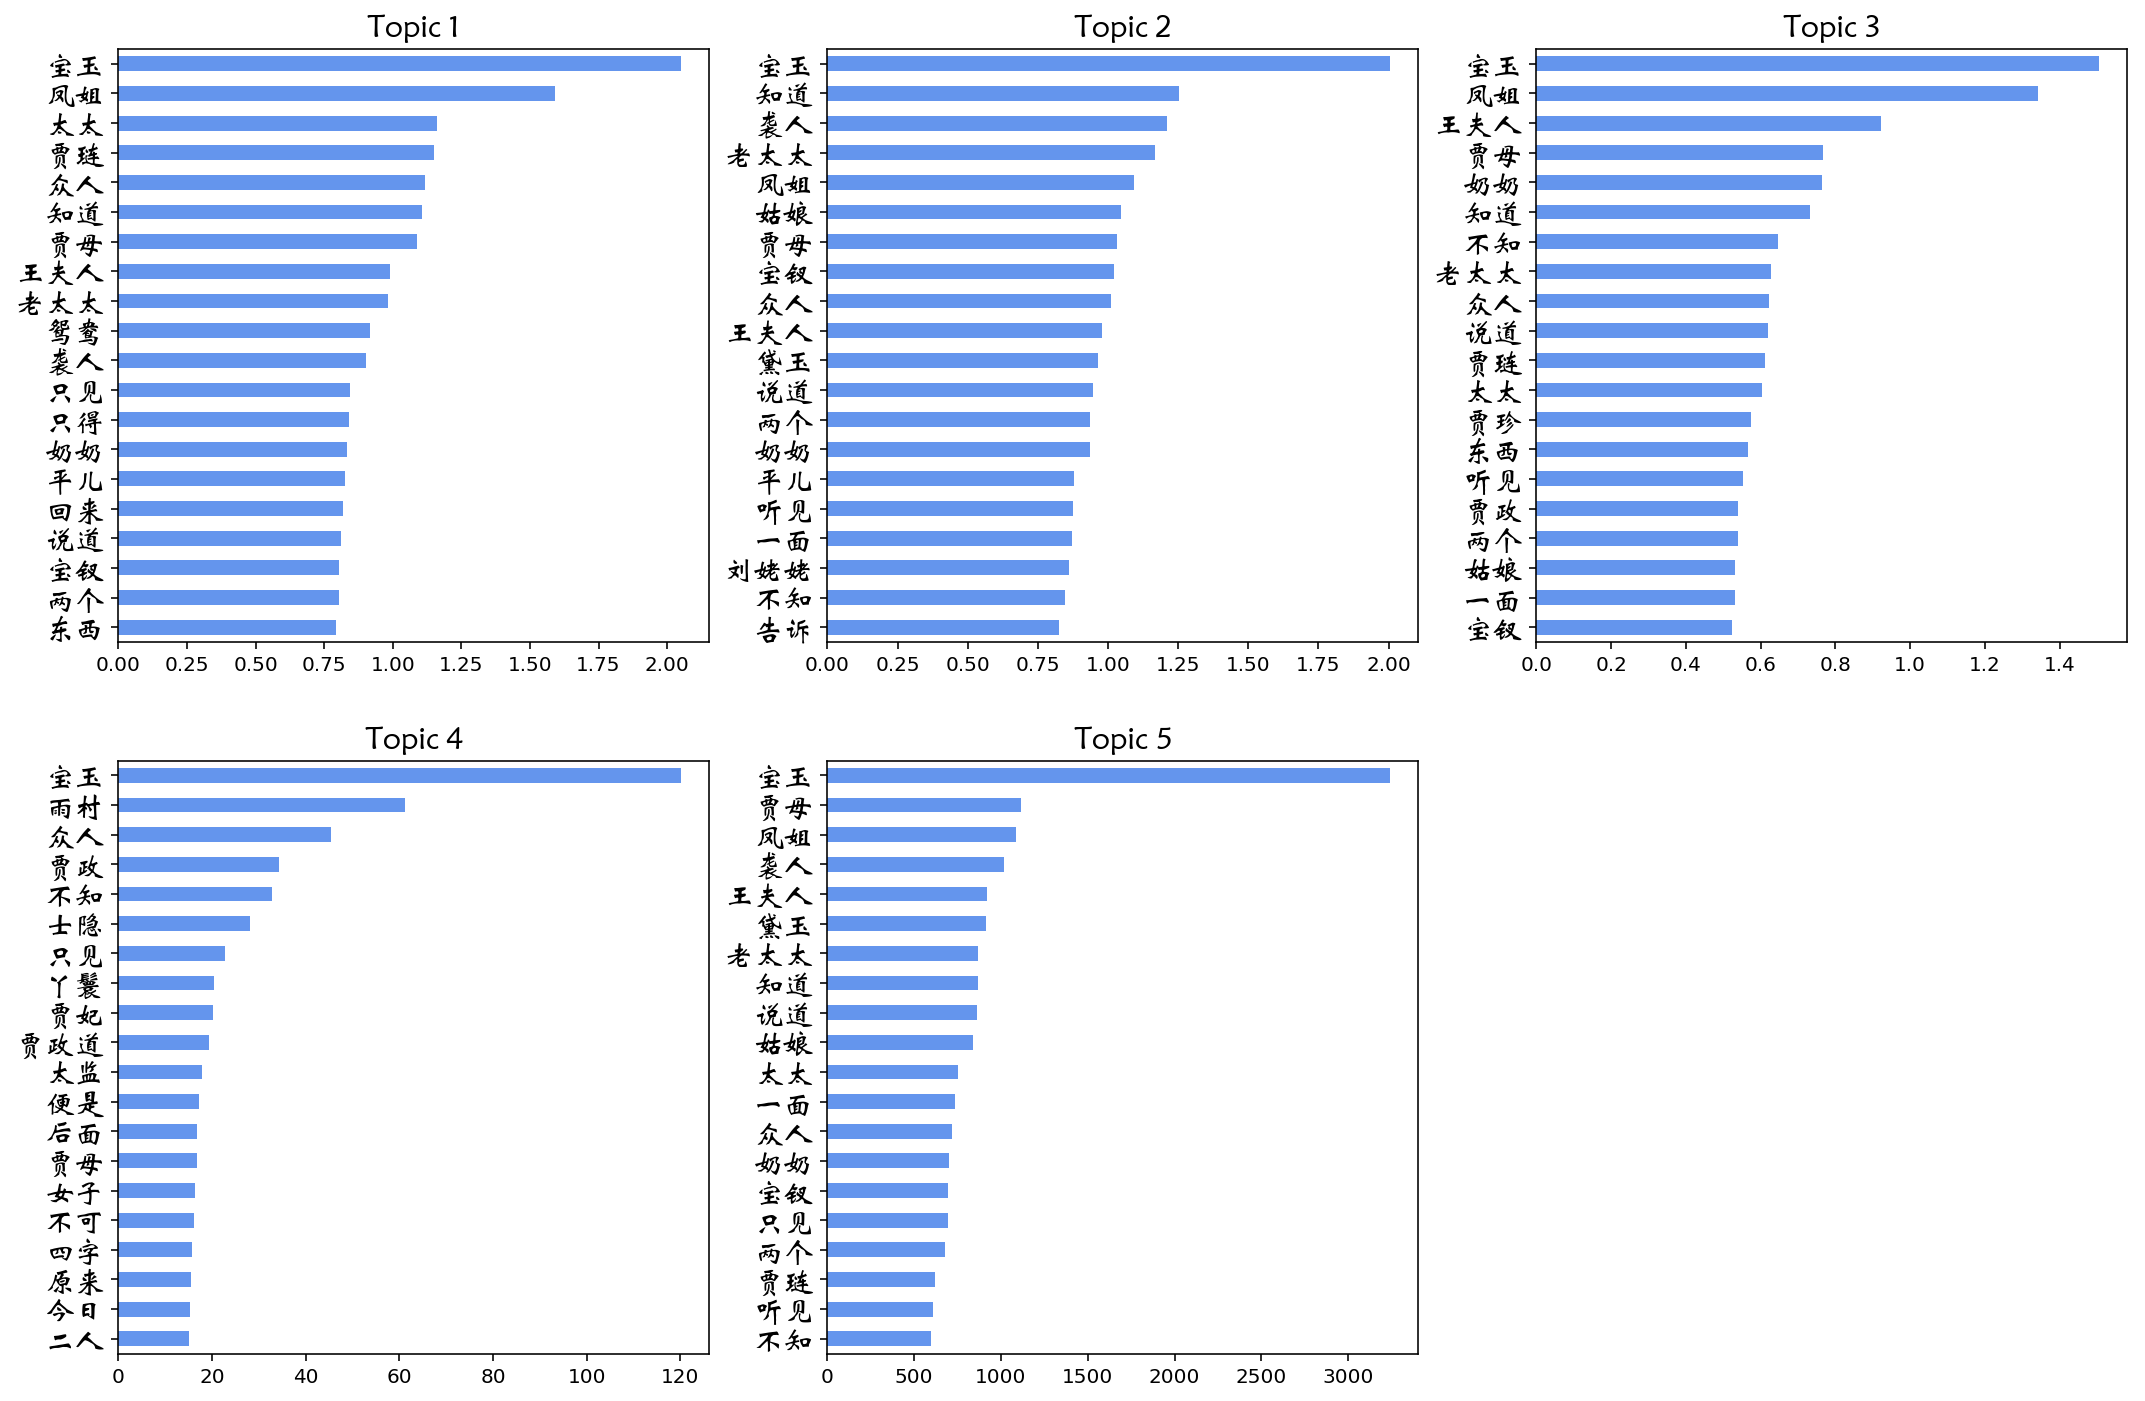

In [34]:
# 查看每个主题的前20个关键词
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names()
fig = plt.figure(figsize=(18,12))
j = 0
for topic_id,topic in enumerate(lda.components_):
    j += 1
    topword = pd.DataFrame({"word":[tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]],
                            "componets":topic[topic.argsort()[:-n_top_words - 1:-1]]})
    topword.sort_values(by = "componets").plot(kind = "barh",x = "word",y = "componets",legend=False,
                                               color='cornflowerblue',subplots=True,ax=fig.add_subplot(2,3,j))
    plt.yticks(FontProperties = font,size=15)
    plt.ylabel("")
    plt.title("Topic %d" %(topic_id+1),FontProperties = font,size= 15)
plt.show()

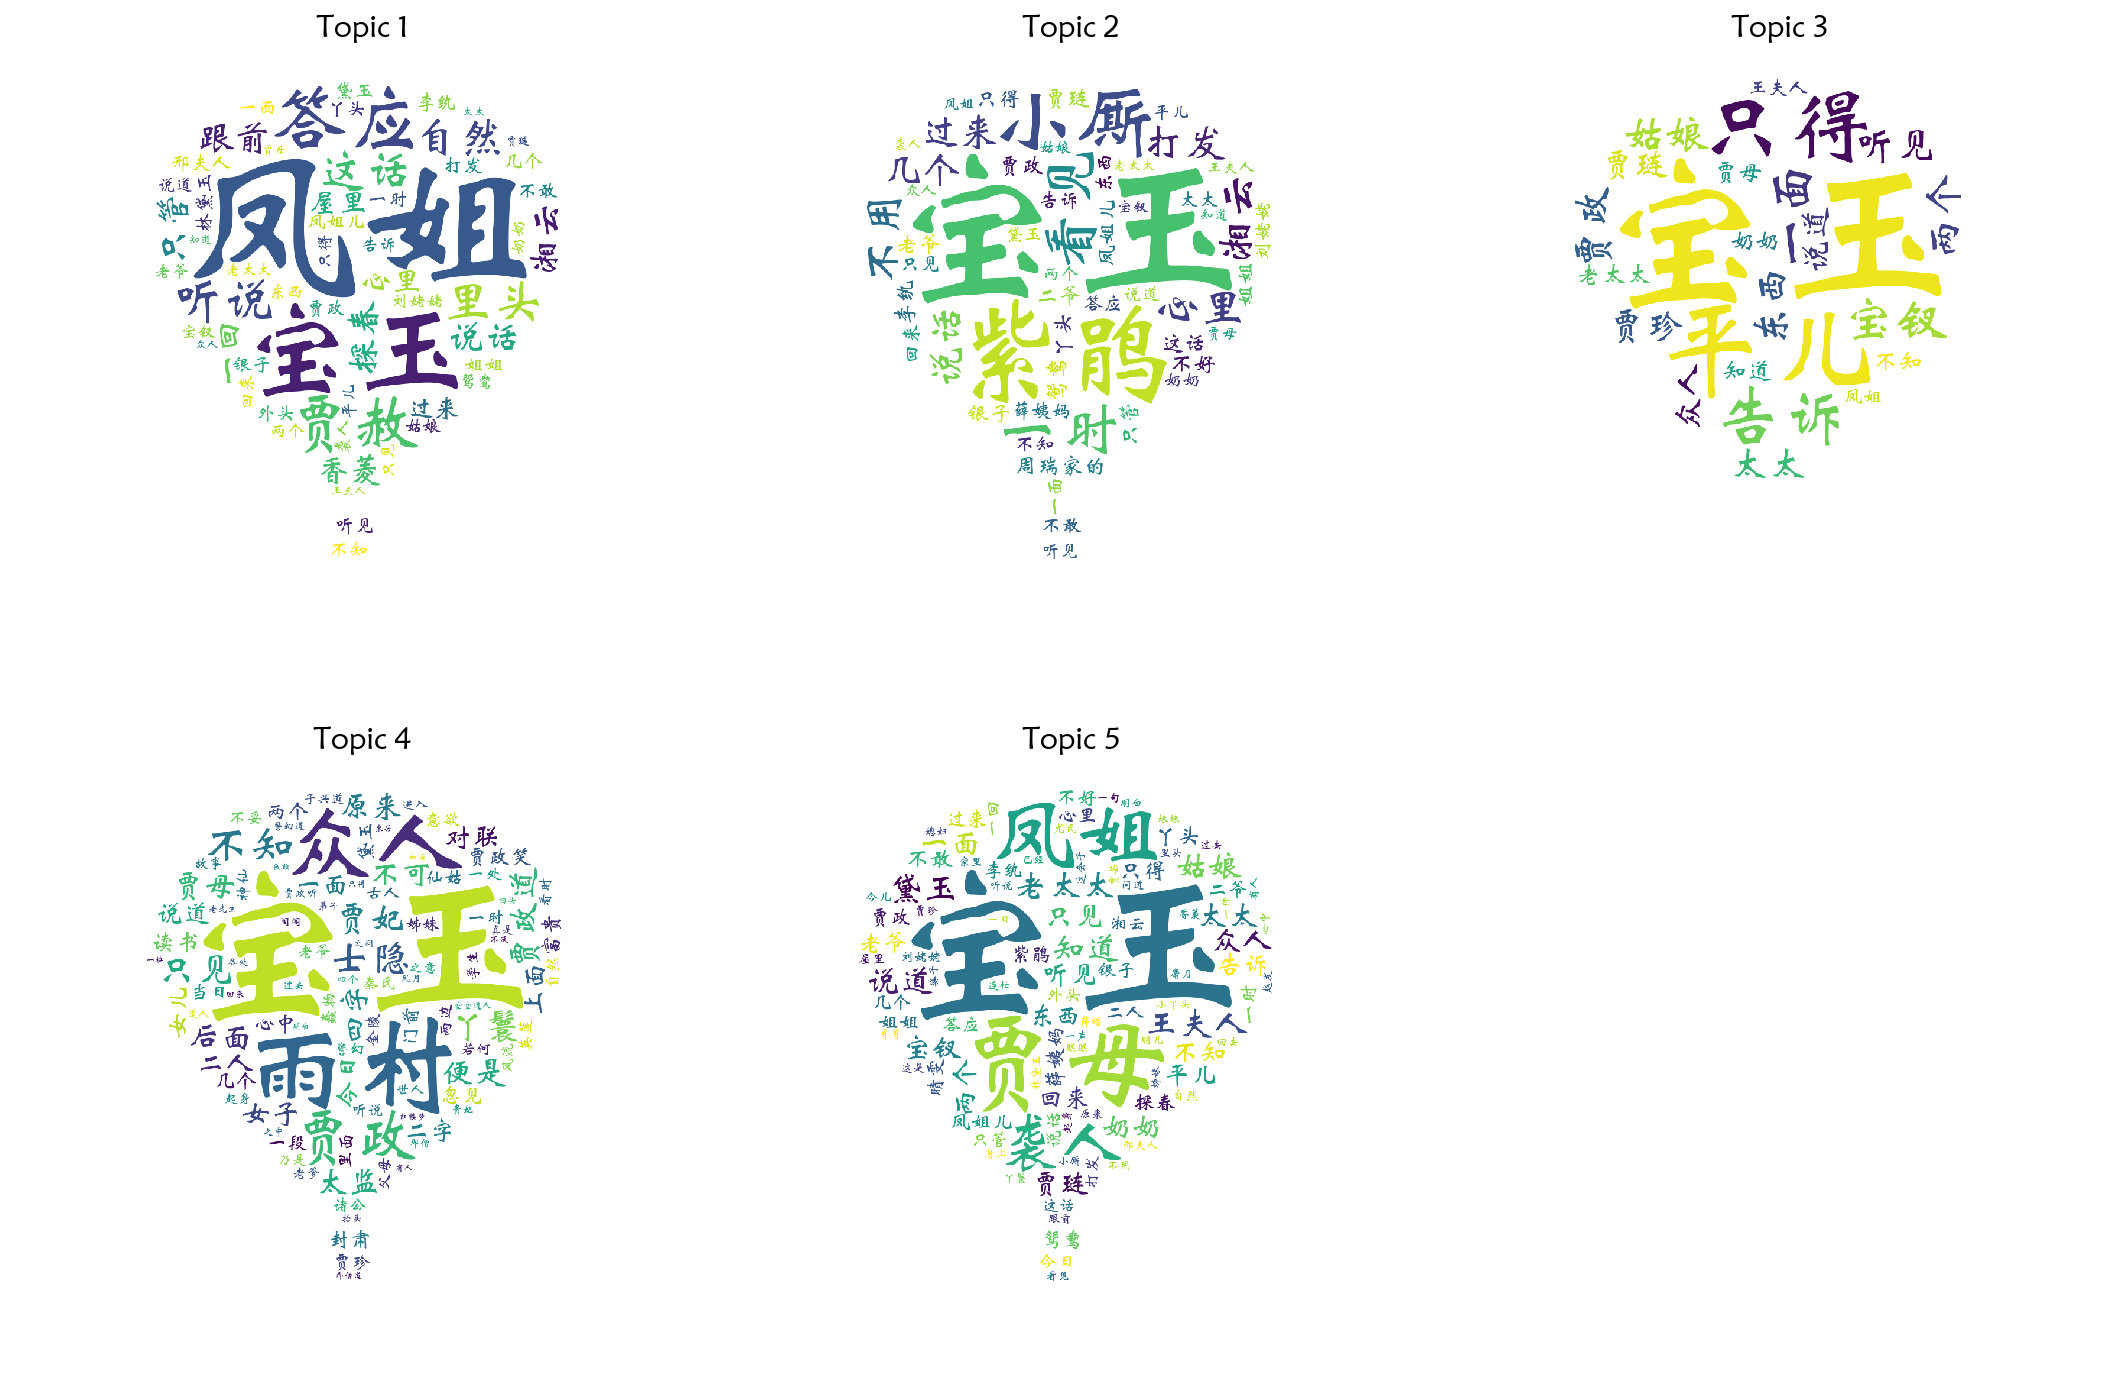

In [35]:
# 查看每个主题的词云
n_top_words = 100

back_coloring = mpimg.imread('词云图片.jpg')
wc = WordCloud(font_path='C:\Windows\Fonts\STXINWEI.TTF',
               margin=5, width=2000, height=2000,
               background_color="white",
               max_words=800,
               mask=back_coloring,
               max_font_size=400,
               random_state=42,
               )
fig = plt.figure(figsize=(18,12))

j = 0
for topic_id,topic in enumerate(lda.components_):
    j += 1
    topword = pd.DataFrame({"word":[tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]],
                            "componets":topic[topic.argsort()[:-n_top_words - 1:-1]]})
    topword = topword.sort_values(by = "componets")
    
    word_dict = {}
    for key,value in zip(topword.word,topword.componets):
        word_dict[key] = round(value)
    plt.subplot(2,3,j)
    plt.imshow(wc.generate_from_frequencies(frequencies=word_dict))
    plt.axis('off')
    plt.title("Topic %d" %(topic_id+1),FontProperties = font,size= 15)
plt.show()

### 4 回应课程任务
#### 4.1 任务1
随机抽取40篇作为训练样本，训练完成后，对剩下的40回进行分类，判断和训练样本中的那些回比较接近

In [37]:
# 生成训练集和测试集的序号
test_index = [i for i in range(80)]
train_index = random.sample(test_index,40)
train_fenci = []
for i in train_index:
    test_index.remove(i)
    train_fenci.append(quanwen_fenci[i])
    
# 将数据调整为CountVectorizer可调用的形式
articals = []
for fenci in train_fenci:
    articals.append(" ".join(fenci))
# 建立能用于模型训练的章节-词频矩阵
tf_vectorizer = CountVectorizer(max_features=10000)
tf = tf_vectorizer.fit_transform(articals)
# 主题数目
n_topics = 5
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=500, 
                                learning_method='online',                 
                                learning_offset=50., random_state=0)
# 模型用于数据
lda.fit(tf)
# 得到每个章节属于某个主题的可能性
chapter_top = pd.DataFrame(lda.transform(tf),index=train_index,columns=np.arange(n_topics)+1)
chapter_top.sort_index()

C:\Users\zhong\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


,1,2,3,4,5
0,0.000131,0.000131,0.000133,0.000131,0.999474
1,0.000178,0.000178,0.000181,0.000178,0.999286
3,0.000161,0.000161,0.000165,0.000161,0.999351
4,0.000144,0.000144,0.000147,0.000144,0.999421
8,0.000183,0.000183,0.999263,0.000183,0.000187
...,...,...,...,...,...
72,0.000144,0.000144,0.999421,0.000144,0.000146
75,0.000157,0.000157,0.999371,0.000157,0.000159
76,0.000103,0.000103,0.999587,0.000103,0.000105
78,0.000205,0.000205,0.999176,0.000205,0.000210


In [38]:
# 计算测试集的主题
test_fenci = []
for i in test_index:
    test_fenci.append(quanwen_fenci[i])
articals_test = []
for fenci in test_fenci:
    articals_test.append(" ".join(fenci))
tf_test = tf_vectorizer.fit_transform(articals_test)
chapter_top_test = pd.DataFrame(lda.transform(tf),index=test_index,columns=np.arange(n_topics)+1)
chapter_top_test.sort_index()

,1,2,3,4,5
2,0.000099,0.000099,0.999604,0.000099,0.000100
5,0.000161,0.000161,0.000165,0.000161,0.999351
6,0.000103,0.000103,0.999587,0.000103,0.000105
7,0.000175,0.000175,0.999299,0.000175,0.000177
12,0.000168,0.000168,0.999325,0.000168,0.000172
...,...,...,...,...,...
68,0.000112,0.000112,0.999550,0.000112,0.000114
69,0.000099,0.000099,0.999601,0.000099,0.000101
73,0.000140,0.000140,0.999437,0.000140,0.000143
74,0.000157,0.000157,0.999371,0.000157,0.000159


In [39]:
# 对每个测试集章节，找到和它最像的训练集章节
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    param vector_a: 向量 a 
    param vector_b: 向量 b
    return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim
result = []
for i in range(len(test_index)):
    cos_sims = []
    for j in range(len(train_index)):
        cos_sims.append(cos_sim(chapter_top_test.loc[test_index[i]],chapter_top.loc[train_index[j]]))
    result.append([test_index[i]+1,train_index[cos_sims.index(max(cos_sims))]+1,max(cos_sims)])
result_df = pd.DataFrame(result,columns=["测试集章节","最相似的训练集章节","相似度"])
result_df

,测试集章节,最相似的训练集章节,相似度
0,3,64,1.0
1,6,4,1.0
2,7,77,1.0
3,8,11,1.0
4,13,48,1.0
...,...,...,...
35,69,71,1.0
36,70,63,1.0
37,74,68,1.0
38,75,76,1.0


#### 4.2 任务2
使用全部八十回，在LDA分析基础上，进行分类，判断哪些回在主题分布上比较接近

In [44]:
# 生成训练集和测试集的序号
train_index_2 = [i for i in range(80)]
train_fenci_2 = []
for i in train_index_2:
    train_fenci_2.append(quanwen_fenci[i])
# 将数据调整为CountVectorizer可调用的形式
articals_2 = []
for fenci in train_fenci_2:
    articals_2.append(" ".join(fenci))
len(articals_2)
# 建立能用于模型训练的章节-词频矩阵
tf_vectorizer = CountVectorizer(max_features=10000)
tf_2 = tf_vectorizer.fit_transform(articals_2)
# 主题数目
n_topics_2 = 5
lda_2 = LatentDirichletAllocation(n_topics=n_topics_2, max_iter=25, 
                                  learning_method='online',
                                  learning_offset=50., random_state=0)
# 模型用于数据
lda_2.fit(tf_2)
# 得到每个章节属于某个主题的可能性
chapter_top_2 = pd.DataFrame(lda_2.transform(tf_2),index=train_index_2,columns=np.arange(n_topics_2)+1)
chapter_top_2.sort_index()

C:\Users\zhong\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


,1,2,3,4,5
0,0.000148,0.000149,0.000149,0.000149,0.999406
1,0.000196,0.000196,0.000196,0.000195,0.999218
2,0.000114,0.000114,0.000114,0.000114,0.999543
3,0.000175,0.000175,0.000175,0.000175,0.999301
4,0.000166,0.000166,0.000166,0.000166,0.999337
...,...,...,...,...,...
75,0.000167,0.000167,0.000167,0.000167,0.999332
76,0.000105,0.000105,0.000106,0.000105,0.999578
77,0.000142,0.000142,0.000142,0.000142,0.999434
78,0.000214,0.000213,0.000213,0.000213,0.999146


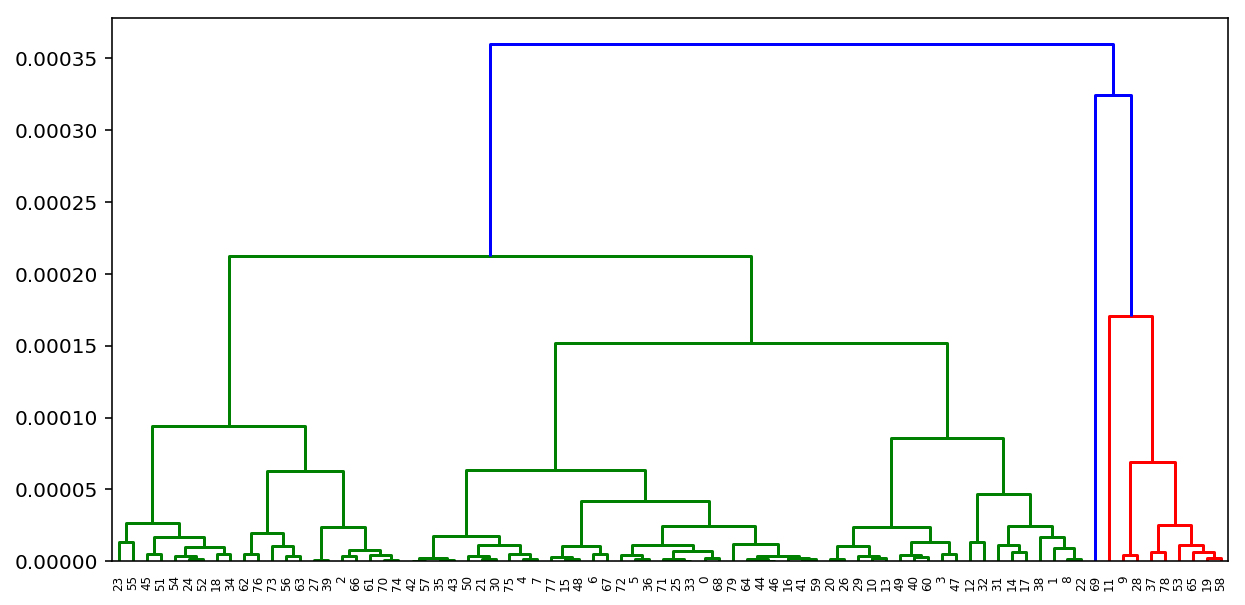

In [45]:
disMat = hierarchy.distance.pdist(chapter_top_2,'euclidean') 
#进行层次聚类:
Z = hierarchy.linkage(disMat,method='average') 
#将层级聚类结果以树状图表示出来并保存为plot_dendrogram.png
fig = plt.figure(figsize=(10,5))
P=hierarchy.dendrogram(Z)
# plt.savefig('plot_dendrogram.png')